In [1]:
from itertools import combinations
import pathlib
from typing import Dict, List
import warnings
import yaml

import lightgbm as lgb
import matplotlib.pyplot as plt
from numba import njit, prange
import numpy as np
import optuna
import pandas as pd
from sklearn.model_selection import TimeSeriesSplit


warnings.simplefilter('ignore')

/home/ss/miniconda3/envs/optiver/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def train_using_cv(
        dataset: pd.DataFrame,
        kfold_params: Dict,
        outputs_dir: pathlib.Path,
    ):
    
    kfold = TimeSeriesSplit(**kfold_params)
    target_columns = ['target']
    feature_columns = [
        col for col in dataset.columns
        if col not in ['date_id', 'target', 'time_id', 'row_id']
    ]
    #feature_columns = ['date_id']
    time = np.arange(dataset['date_id'].min(), dataset['date_id'].max())
    oof_true = []
    oof_pred = []
    fimps = []
    best_param_records = {}
    best_value_records = {}
    history = {
        'train_mae': [],
        'valid_mae': [],
    }
    for k, (train_indices, valid_indices) in enumerate(kfold.split(time)):
        #if k != 4: continue
        print(f'fold {k+1}')
        train_time = time[train_indices]
        valid_time = time[valid_indices]
        print(train_time)
        print(valid_time)
        print(train_time.shape, np.min(train_time), np.max(train_time))
        print(valid_time.shape, np.min(valid_time), np.max(valid_time))

        plot_time(time, train_time, valid_time)
        
        train_X = dataset.query('date_id in @train_time')[feature_columns]
        train_y = dataset.query('date_id in @train_time')[target_columns]
        valid_X = dataset.query('date_id in @valid_time')[feature_columns]
        valid_y = dataset.query('date_id in @valid_time')[target_columns]
        print(f'train_X.shape: {train_X.shape}, train_y.shape: {train_y.shape}')
        print(f'valid_X.shape: {valid_X.shape}, valid_y.shape: {valid_y.shape}')
        train_X = train_X
        train_y = train_y.values.reshape(-1)
        valid_X = valid_X
        valid_y = valid_y.values.reshape(-1)
        
        objective = Objective(train_X, train_y, valid_X, valid_y)
        study = optuna.create_study(sampler=optuna.samplers.TPESampler(seed=42))
        optuna.logging.set_verbosity(optuna.logging.WARNING)
        study.optimize(objective, n_trials=5)
        best_params = study.best_params
        add_params = {
            'task': 'train',
            'boosting_type': 'gbdt',
            'objective': 'mae',
            'metric': 'mae',
            'seed': 42,
        }
        best_params.update(add_params)

        [print(f'{k}: {v}') for k, v in best_params.items()]
        print(f'best value: {study.best_value}')

        best_param_records[f'fold{k+1}'] = best_params
        best_value_records[f'fold{k+1}'] = study.best_value
        callbacks = [
            lgb.early_stopping(stopping_rounds=100, verbose=True),
            lgb.log_evaluation(100),
        ]
        
        train_dataset = lgb.Dataset(train_X, train_y)
        valid_dataset = lgb.Dataset(valid_X, valid_y)
        
        model = lgb.train(
            params=best_params,
            train_set=train_dataset,
            valid_sets=[train_dataset, valid_dataset],
            valid_names=['train', 'valid'],
            callbacks=callbacks,
            num_boost_round=3000,
        )
        model.save_model(
            outputs_dir.joinpath(f'lightgbm_optuna_group_fold{k+1}'),
            num_iteration=model.best_iteration
        )

        fimp = model.feature_importance(importance_type='gain')
        fimp = pd.DataFrame(fimp, index=feature_columns, columns=[f'fold{k+1}'])
        fimps.append(fimp)
        
        oof_true.append(valid_y)
        oof_pred.append(model.predict(valid_X, num_iteration=model.best_iteration))

        history['train_mae'].append(np.mean(abs(train_y - model.predict(train_X, num_iteration=model.best_iteration))))
        history['valid_mae'].append(np.mean(abs(valid_y - model.predict(valid_X, num_iteration=model.best_iteration))))
    
    fimps = pd.concat(fimps, axis=1)
    
    mean_fimps = fimps.mean(axis=1)
    std_fimps = fimps.std(axis=1)
    fimps['mean_fimps'] = mean_fimps
    fimps['std_fimps'] = std_fimps
    fimps.sort_values(by='mean_fimps', inplace=True)
    display(fimps)
    
    fimps['mean_fimps'].plot(kind='barh', xerr=fimps['std_fimps'], capsize=3)
    plt.show()
    
    oof_true = np.concatenate(oof_true)
    oof_pred = np.concatenate(oof_pred)
    oof_mae = np.mean(abs(oof_true - oof_pred))
    print(f'oof mae: {oof_mae:.4f}')

    _, ax = plt.subplots()
    bins = np.linspace(-20, 20, 100)
    ax.hist(oof_true, bins=bins, histtype='step', label='truth')
    ax.hist(oof_pred, bins=bins, histtype='step', label='regression')
    ax.legend()
    plt.show()
    
    with open(outputs_dir.joinpath('result_lightgbm_optuna.yaml'), 'w') as f:
        yaml.dump(
            {
                'best_param_records': best_param_records,
                'best_value_records': best_value_records,
                'oof rmse': oof_mae.item(),
            },
            f,
            default_flow_style=False
        )
    return pd.DataFrame.from_dict(history)


class Objective:
    def __init__(self, train_X, train_y, valid_X, valid_y):
        self.train_X = train_X
        self.train_y = train_y
        self.valid_X = valid_X
        self.valid_y = valid_y

    def __call__(self, trial):
        params = {
            'task': 'train',
            'boosting_type': 'gbdt',
            'objective': 'mae',
            'metric': 'mae',
            'learning_rate': trial.suggest_float('learning_rate', 1e-03, 1e-01),
            'seed': 42,
            'max_depth':  trial.suggest_int('max_depth', 3, 10),
            #'num_leaves': trial.suggest_int('max_depth', 31, 127),
            #'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 20, 100),
            #'feature_fraction': trial.suggest_float('feature_fraction', 0.4, 1.0),
            #'feature_fraction_bynode': trial.suggest_float('feature_fraction_bynode', 0.4, 1.0),
            #'lambda_l2': trial.suggest_float('lambda_l2', 0.1, 10),
            'verbose': -1,
        }
        
        callbacks = [
            lgb.early_stopping(stopping_rounds=100, verbose=True),
            lgb.log_evaluation(0),
        ]
        train_dataset = lgb.Dataset(self.train_X, self.train_y)
        valid_dataset = lgb.Dataset(self.valid_X, self.valid_y)
        model = lgb.train(
            params=params,
            train_set=train_dataset,
            valid_sets=[train_dataset, valid_dataset],
            valid_names=['train', 'valid'],
            callbacks=callbacks,
            num_boost_round=3000,
        )

        preds = model.predict(self.valid_X, num_iteration=model.best_iteration)
        mae = np.mean(abs(preds - self.valid_y))
        return mae
    

def plot_time(all_time, train_time, valid_time):
    _, ax = plt.subplots()
    ax.barh(y='all', height=0.6, width=len(all_time), left=0, color='tab:blue')
    ax.barh(y='train+valid', height=0.6, width=[len(train_time), len(valid_time)],
            left=[train_time.min(), valid_time.min()], color=['tab:orange', 'tab:green'])
    xcenter = [len(all_time)//2, train_time.min()+len(train_time)//2, valid_time.min()+len(valid_time)//2]
    ycenter = [0, 1, 1]
    width = [len(all_time), len(train_time), len(valid_time)]
    for x, y, w in zip(xcenter, ycenter, width):
        ax.text(x, y, str(w),  ha='center', va='center')
    if kfold_params['gap'] > 0:
        ax.set_xticks([train_time.min(), train_time.max(), valid_time.min(), valid_time.max(), time.max()])
    else:
        ax.set_xticks([train_time.min(), train_time.max(), valid_time.max(), len(all_time)])
    ax.grid(axis='x', linestyle='--')
    ax.tick_params(axis='x', labelrotation=45)
    plt.show()

In [3]:
def preprocess(df_):
    df_.eval('diff_ask_bid_price = ask_price - bid_price', inplace=True)
    df_.eval('sum_ask_bid_price = ask_price + bid_price', inplace=True)
    df_.eval('diff_ask_bid_size = ask_size - bid_size', inplace=True)
    df_.eval('sum_ask_bid_size = ask_size + bid_size', inplace=True)
    df_.eval('imbalance_buy_sell_flag = imbalance_buy_sell_flag + 1', inplace=True)
    df_.eval('diff_far_near_price = far_price - near_price', inplace=True)
    df_.eval('sum_far_near_price = far_price + near_price', inplace=True)
    # df_['weight'] = (
    #     df_[['stock_id', 'target']]
    #     .groupby('stock_id')
    #     .transform(lambda x: abs((x - x.quantile(0.50))))
    # )

In [4]:
inputs_dir_path = pathlib.Path('../inputs')
outputs_dir_path = pathlib.Path('../outputs')
if not outputs_dir_path.is_dir():
    outputs_dir_path.mkdir()

train_df = pd.read_csv(inputs_dir_path. joinpath('train.csv'))
train_df = train_df.dropna(subset=['target'])
preprocess(train_df)
display(train_df)

,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,...,wap,target,time_id,row_id,diff_ask_bid_price,sum_ask_bid_price,diff_ask_bid_size,sum_ask_bid_size,diff_far_near_price,sum_far_near_price
0,0,0,0,3180602.69,2,0.999812,13380276.64,NaN,NaN,0.999812,...,1.000000,-3.029704,0,0_0_0,0.000214,1.999838,-52158.47,69144.53,NaN,NaN
1,1,0,0,166603.91,0,0.999896,1642214.25,NaN,NaN,0.999896,...,1.000000,-5.519986,0,0_0_1,0.000764,2.000556,17372.05,23838.13,NaN,NaN
2,2,0,0,302879.87,0,0.999561,1819368.03,NaN,NaN,0.999403,...,1.000000,-8.389950,0,0_0_2,0.000895,1.999701,-18961.00,56951.00,NaN,NaN
3,3,0,0,11917682.27,0,1.000171,18389745.62,NaN,NaN,0.999999,...,1.000000,-4.010200,0,0_0_3,0.000215,2.000213,476707.50,481357.30,NaN,NaN
4,4,0,0,447549.96,0,0.999532,17860614.95,NaN,NaN,0.999394,...,1.000000,-7.349849,0,0_0_4,0.000622,1.999410,-16051.44,16919.64,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5237975,195,480,540,2440722.89,0,1.000317,28280361.74,0.999734,0.999734,1.000317,...,1.000328,2.310276,26454,480_540_195,0.000117,2.000751,287605.36,352119.44,0.000000,1.999468
5237976,196,480,540,349510.47,0,1.000643,9187699.11,1.000129,1.000386,1.000643,...,1.000819,-8.220077,26454,480_540_196,0.000257,2.001543,-111715.33,298501.47,-0.000257,2.000515
5237977,197,480,540,0.00,1,0.995789,12725436.10,0.995789,0.995789,0.995789,...,0.995797,1.169443,26454,480_540_197,0.000094,1.991672,163247.66,196828.98,0.000000,1.991578
5237978,198,480,540,1000898.84,2,0.999210,94773271.05,0.999210,0.999210,0.998970,...,0.999008,-1.540184,26454,480_540_198,0.000240,1.998180,544261.28,795524.72,0.000000,1.998420


fold 1
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]
[30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53
 54 55 56 57 58 59]
(30,) 0 29
(30,) 30 59


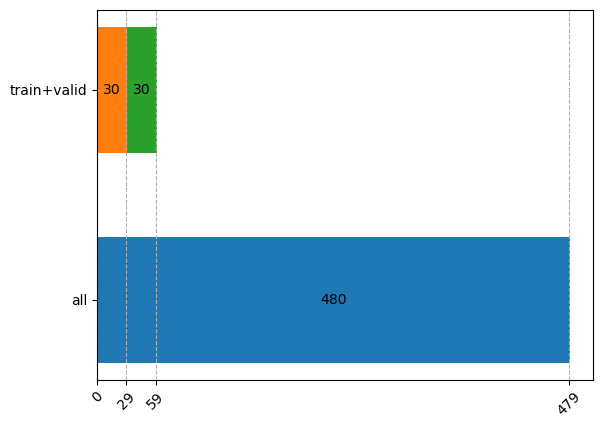

[I 2023-10-29 21:21:54,392] A new study created in memory with name: no-name-7f1cecbb-f9fe-43da-84c1-50fe4c23f406


train_X.shape: (316580, 19), train_y.shape: (316580, 1)
valid_X.shape: (319354, 19), valid_y.shape: (319354, 1)
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[130]	train's l1: 4.99971	valid's l1: 5.21063
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[65]	train's l1: 5.00363	valid's l1: 5.21104
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[510]	train's l1: 5.01417	valid's l1: 5.21425
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[766]	train's l1: 4.99674	valid's l1: 5.21083
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[85]	train's l1: 4.99821	valid's l1: 5.2103
learning_rate: 0.06051038616257767
max_depth: 8
task: train
boosting_type: gbdt
objective: mae
metric: mae
seed: 42
best value: 5.210295936569999
[LightGBM] [Warning] Accuracy 

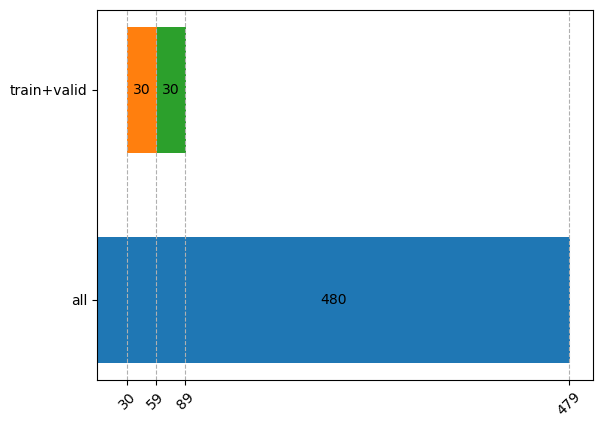

train_X.shape: (319354, 19), train_y.shape: (319354, 1)
valid_X.shape: (322960, 19), valid_y.shape: (322960, 1)
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[221]	train's l1: 5.12292	valid's l1: 6.3987
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[108]	train's l1: 5.13032	valid's l1: 6.40081
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[805]	train's l1: 5.14839	valid's l1: 6.40041
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[919]	train's l1: 5.14388	valid's l1: 6.399
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[108]	train's l1: 5.14168	valid's l1: 6.39893
learning_rate: 0.03807947176588889
max_depth: 10
task: train
boosting_type: gbdt
objective: mae
metric: mae
seed: 42
best value: 6.398703699713543
[LightGBM] [Warning] Accuracy

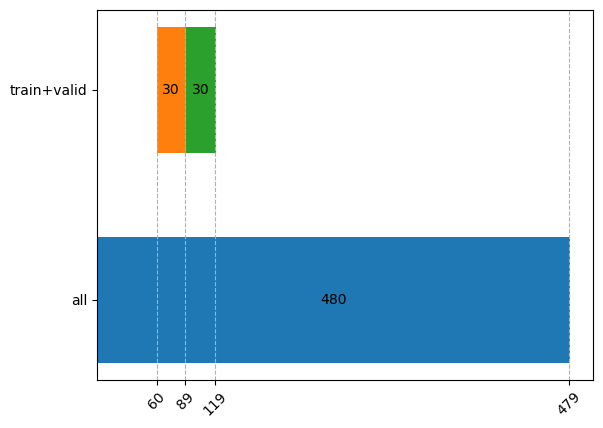

train_X.shape: (322960, 19), train_y.shape: (322960, 1)
valid_X.shape: (325050, 19), valid_y.shape: (325050, 1)
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[229]	train's l1: 6.2855	valid's l1: 6.89419
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[108]	train's l1: 6.29776	valid's l1: 6.89629
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[719]	train's l1: 6.33084	valid's l1: 6.89699
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1109]	train's l1: 6.30053	valid's l1: 6.89421
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[170]	train's l1: 6.26877	valid's l1: 6.89474
learning_rate: 0.03807947176588889
max_depth: 10
task: train
boosting_type: gbdt
objective: mae
metric: mae
seed: 42
best value: 6.894186736168267
[LightGBM] [Warning] Accur

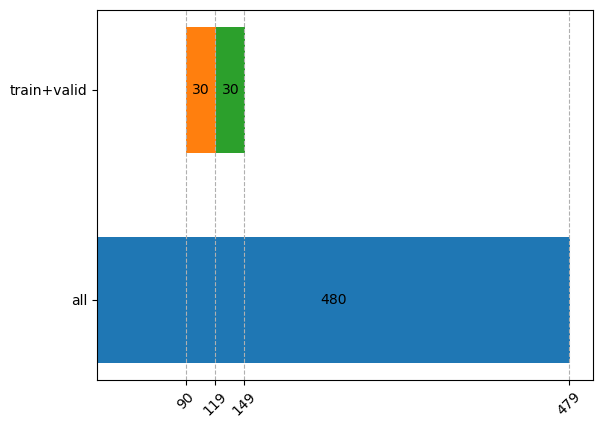

train_X.shape: (325050, 19), train_y.shape: (325050, 1)
valid_X.shape: (324995, 19), valid_y.shape: (324995, 1)
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[137]	train's l1: 6.81466	valid's l1: 7.70732
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[79]	train's l1: 6.80872	valid's l1: 7.70646
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[478]	train's l1: 6.83894	valid's l1: 7.7084
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[865]	train's l1: 6.80629	valid's l1: 7.70562
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[94]	train's l1: 6.80796	valid's l1: 7.70686
learning_rate: 0.006750277604651747
max_depth: 9
task: train
boosting_type: gbdt
objective: mae
metric: mae
seed: 42
best value: 7.70561670146408
[LightGBM] [Warning] Accuracy 

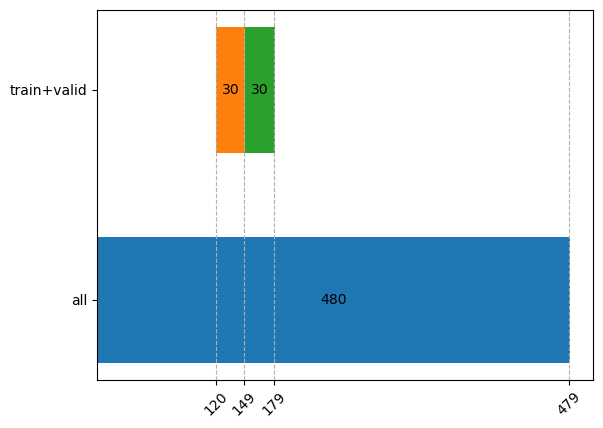

train_X.shape: (324995, 19), train_y.shape: (324995, 1)
valid_X.shape: (325050, 19), valid_y.shape: (325050, 1)
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[142]	train's l1: 7.59541	valid's l1: 6.55578
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[68]	train's l1: 7.60591	valid's l1: 6.55523
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[512]	train's l1: 7.62976	valid's l1: 6.55662
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[873]	train's l1: 7.59003	valid's l1: 6.55442
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[125]	train's l1: 7.57054	valid's l1: 6.55574
learning_rate: 0.006750277604651747
max_depth: 9
task: train
boosting_type: gbdt
objective: mae
metric: mae
seed: 42
best value: 6.554415181538907
[LightGBM] [Warning] Accura

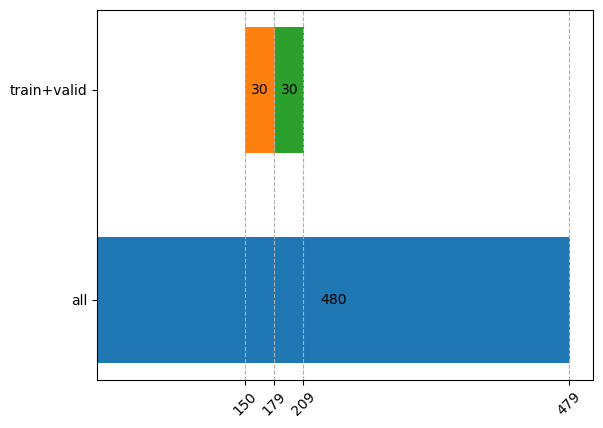

train_X.shape: (325050, 19), train_y.shape: (325050, 1)
valid_X.shape: (327690, 19), valid_y.shape: (327690, 1)
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[200]	train's l1: 6.45249	valid's l1: 7.62222
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[72]	train's l1: 6.48169	valid's l1: 7.62179
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[910]	train's l1: 6.46571	valid's l1: 7.62317
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[716]	train's l1: 6.48656	valid's l1: 7.6226
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[95]	train's l1: 6.47475	valid's l1: 7.62211
learning_rate: 0.07346740023932911
max_depth: 7
task: train
boosting_type: gbdt
objective: mae
metric: mae
seed: 42
best value: 7.621786499572281
[LightGBM] [Warning] Accuracy 

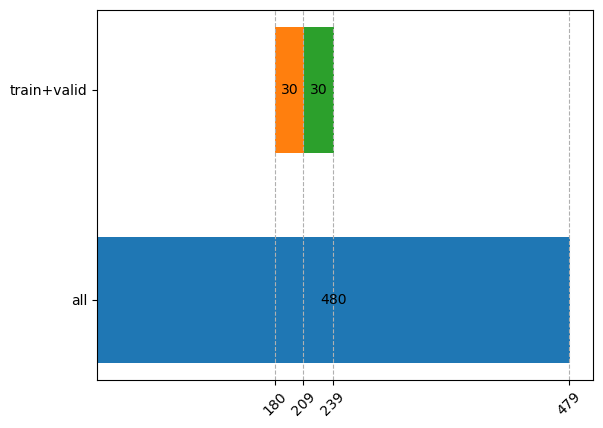

train_X.shape: (327690, 19), train_y.shape: (327690, 1)
valid_X.shape: (328350, 19), valid_y.shape: (328350, 1)
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[182]	train's l1: 7.5183	valid's l1: 6.43121
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[68]	train's l1: 7.54584	valid's l1: 6.43324
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[646]	train's l1: 7.55145	valid's l1: 6.43396
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1035]	train's l1: 7.51883	valid's l1: 6.43082
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[97]	train's l1: 7.53457	valid's l1: 6.43154
learning_rate: 0.006750277604651747
max_depth: 9
task: train
boosting_type: gbdt
objective: mae
metric: mae
seed: 42
best value: 6.430819282513593
[LightGBM] [Warning] Accurac

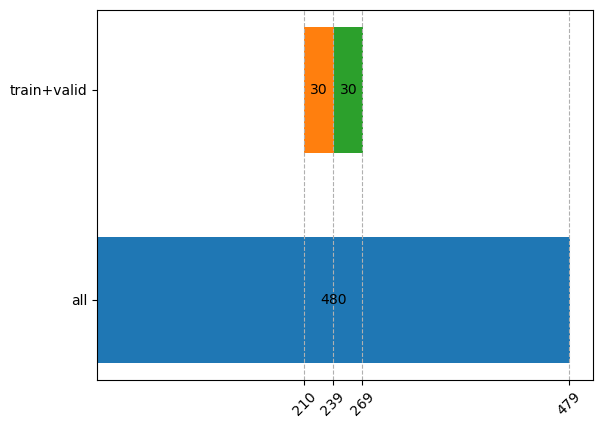

train_X.shape: (328350, 19), train_y.shape: (328350, 1)
valid_X.shape: (328350, 19), valid_y.shape: (328350, 1)
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[147]	train's l1: 6.35166	valid's l1: 5.83775
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[66]	train's l1: 6.36358	valid's l1: 5.83726
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[720]	train's l1: 6.3587	valid's l1: 5.83847
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[848]	train's l1: 6.35127	valid's l1: 5.83758
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[88]	train's l1: 6.35681	valid's l1: 5.83871
learning_rate: 0.07346740023932911
max_depth: 7
task: train
boosting_type: gbdt
objective: mae
metric: mae
seed: 42
best value: 5.837261532670931
[LightGBM] [Warning] Accuracy 

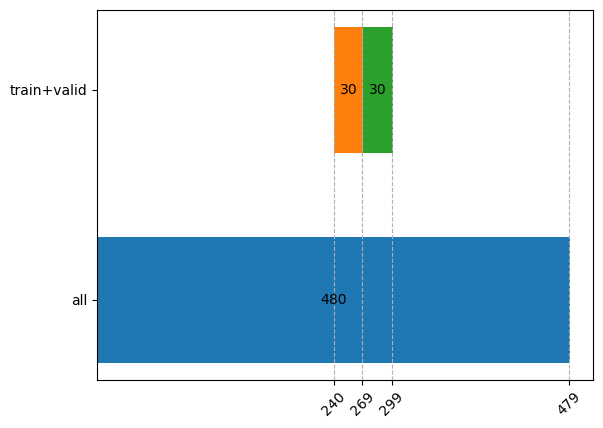

train_X.shape: (328350, 19), train_y.shape: (328350, 1)
valid_X.shape: (328625, 19), valid_y.shape: (328625, 1)
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[197]	train's l1: 5.74838	valid's l1: 6.06256
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[60]	train's l1: 5.78441	valid's l1: 6.06331
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[528]	train's l1: 5.79192	valid's l1: 6.06434
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1153]	train's l1: 5.74655	valid's l1: 6.06176
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[71]	train's l1: 5.78316	valid's l1: 6.06209
learning_rate: 0.006750277604651747
max_depth: 9
task: train
boosting_type: gbdt
objective: mae
metric: mae
seed: 42
best value: 6.061759856696877
[LightGBM] [Warning] Accura

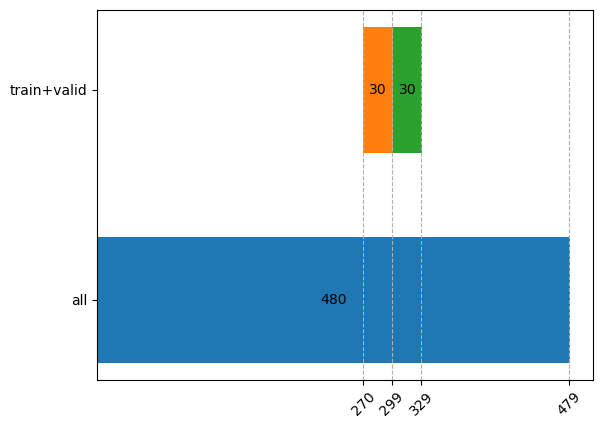

train_X.shape: (328625, 19), train_y.shape: (328625, 1)
valid_X.shape: (329944, 19), valid_y.shape: (329944, 1)
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[211]	train's l1: 5.97394	valid's l1: 6.55693
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[122]	train's l1: 5.96904	valid's l1: 6.55655
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[766]	train's l1: 6.0039	valid's l1: 6.55715
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1039]	train's l1: 5.98376	valid's l1: 6.55636
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[220]	train's l1: 5.93475	valid's l1: 6.55697
learning_rate: 0.006750277604651747
max_depth: 9
task: train
boosting_type: gbdt
objective: mae
metric: mae
seed: 42
best value: 6.5563615821749766
[LightGBM] [Warning] Accu

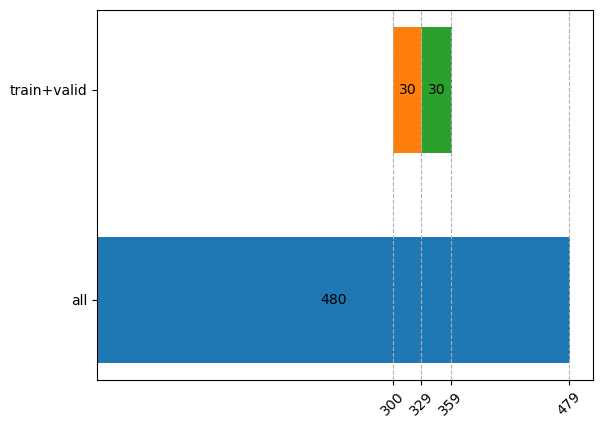

train_X.shape: (329944, 19), train_y.shape: (329944, 1)
valid_X.shape: (330000, 19), valid_y.shape: (330000, 1)
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[161]	train's l1: 6.46198	valid's l1: 6.21454
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[82]	train's l1: 6.46522	valid's l1: 6.21601
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[498]	train's l1: 6.4961	valid's l1: 6.21625
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[770]	train's l1: 6.47361	valid's l1: 6.2142
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[80]	train's l1: 6.47679	valid's l1: 6.21364
learning_rate: 0.06051038616257767
max_depth: 8
task: train
boosting_type: gbdt
objective: mae
metric: mae
seed: 42
best value: 6.213635737806325
[LightGBM] [Warning] Accuracy m

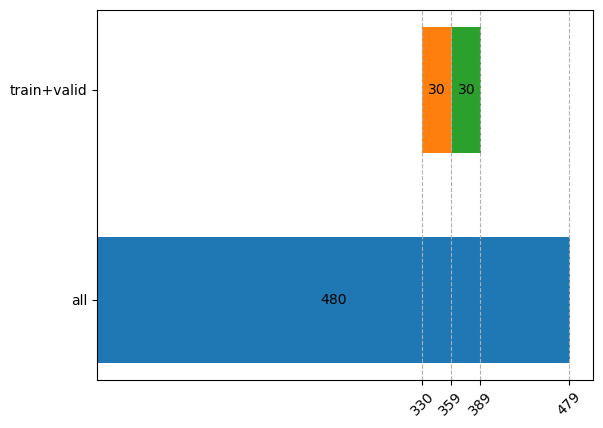

train_X.shape: (330000, 19), train_y.shape: (330000, 1)
valid_X.shape: (329945, 19), valid_y.shape: (329945, 1)
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[179]	train's l1: 6.1199	valid's l1: 6.44584
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[60]	train's l1: 6.15263	valid's l1: 6.44628
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[382]	train's l1: 6.17638	valid's l1: 6.45291
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[866]	train's l1: 6.13234	valid's l1: 6.44528
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[82]	train's l1: 6.14421	valid's l1: 6.44603
learning_rate: 0.006750277604651747
max_depth: 9
task: train
boosting_type: gbdt
objective: mae
metric: mae
seed: 42
best value: 6.445277298638929
[LightGBM] [Warning] Accuracy

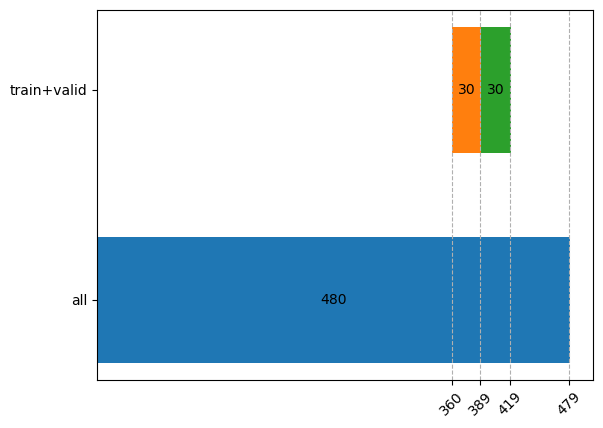

train_X.shape: (329945, 19), train_y.shape: (329945, 1)
valid_X.shape: (330000, 19), valid_y.shape: (330000, 1)
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[195]	train's l1: 6.34951	valid's l1: 6.37382
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[84]	train's l1: 6.36491	valid's l1: 6.37529
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[836]	train's l1: 6.37245	valid's l1: 6.37721
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1310]	train's l1: 6.33337	valid's l1: 6.37259
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[127]	train's l1: 6.34807	valid's l1: 6.37296
learning_rate: 0.006750277604651747
max_depth: 9
task: train
boosting_type: gbdt
objective: mae
metric: mae
seed: 42
best value: 6.372592550098045
[LightGBM] [Warning] Accur

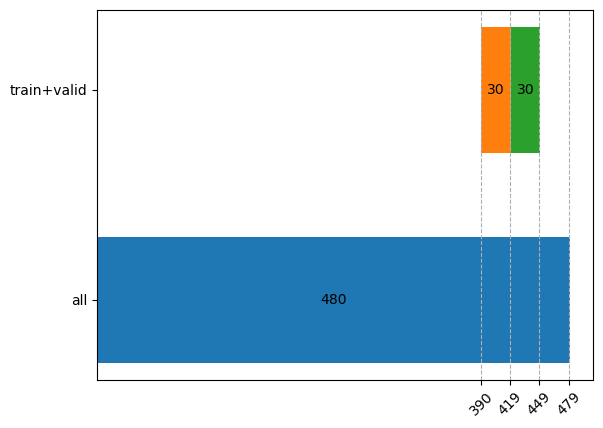

train_X.shape: (330000, 19), train_y.shape: (330000, 1)
valid_X.shape: (329999, 19), valid_y.shape: (329999, 1)
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[97]	train's l1: 6.32293	valid's l1: 5.62618
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[54]	train's l1: 6.3218	valid's l1: 5.62849
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[255]	train's l1: 6.35268	valid's l1: 5.62959
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[534]	train's l1: 6.32478	valid's l1: 5.6257
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[59]	train's l1: 6.32487	valid's l1: 5.6261
learning_rate: 0.006750277604651747
max_depth: 9
task: train
boosting_type: gbdt
objective: mae
metric: mae
seed: 42
best value: 5.625700575752068
[LightGBM] [Warning] Accuracy ma

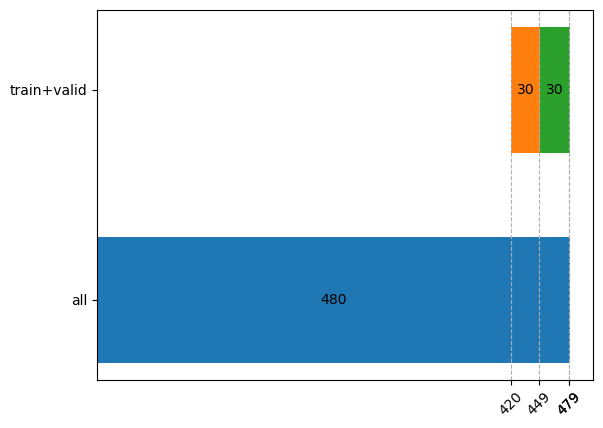

train_X.shape: (329999, 19), train_y.shape: (329999, 1)
valid_X.shape: (330000, 19), valid_y.shape: (330000, 1)
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[122]	train's l1: 5.57663	valid's l1: 5.89906
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[75]	train's l1: 5.56982	valid's l1: 5.90077
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[502]	train's l1: 5.58971	valid's l1: 5.90126
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[695]	train's l1: 5.57642	valid's l1: 5.8993
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[62]	train's l1: 5.58818	valid's l1: 5.90045
learning_rate: 0.03807947176588889
max_depth: 10
task: train
boosting_type: gbdt
objective: mae
metric: mae
seed: 42
best value: 5.899063164985639
[LightGBM] [Warning] Accuracy

,fold1,fold2,fold3,fold4,fold5,fold6,fold7,fold8,fold9,fold10,fold11,fold12,fold13,fold14,fold15,mean_fimps,std_fimps
sum_ask_bid_size,418.598351,1578.633335,1556.001821,6110.432222,5969.847117,635.454096,7834.270715,696.631897,12967.193560,12934.256320,1455.749296,14422.987442,16044.328767,3477.353203,1343.611407,5829.689970,5653.400715
sum_ask_bid_price,975.556859,2508.458399,1784.204345,10084.125722,9757.792228,586.275793,11012.774996,718.801679,12475.092273,12089.567507,1247.699700,11263.135324,15265.276455,5641.489480,1737.720602,6476.531424,5334.299812
sum_far_near_price,1796.719708,3579.166543,3660.018616,14956.195407,8561.508163,726.988828,14047.396639,1444.476101,22050.930353,14990.308886,1442.082107,16107.672164,18035.274908,11398.112270,1998.110093,8986.330719,7303.247786
imbalance_buy_sell_flag,3624.090774,6065.666102,3725.029916,10219.090011,19181.461228,980.540895,17125.028954,834.460497,12682.533020,12983.870566,2462.721780,28154.618460,19061.268194,15020.643479,2232.550897,10290.238318,8301.724483
bid_price,2307.716516,5095.607019,5746.885919,16724.482303,20956.409187,1145.524526,18533.500928,1214.542997,25410.121029,21763.122294,1443.008964,19626.314380,24509.558886,7641.455286,2150.359572,11617.907320,9543.714814
far_price,1221.383566,5239.484562,4690.870512,19236.554294,16742.907934,1496.301357,21560.045029,2188.450604,23781.465277,16090.016593,1744.413706,18735.807559,28447.763452,11509.623117,2634.774506,11687.990805,9453.850178
ask_price,2034.767310,5083.406002,5212.201162,19740.322870,18313.062582,1209.464633,14767.740642,1267.745597,17986.222746,18287.113579,2270.735603,24464.033589,26416.925742,20013.816828,2909.606517,11998.477694,9305.688113
wap,3537.269001,6964.914714,7286.292984,31344.561158,47855.646784,3214.202909,23041.255260,1974.219155,19760.074856,17818.614485,2046.000793,21816.452351,15361.896092,11300.409718,2399.739748,14381.436667,13057.707765
diff_far_near_price,1586.565412,5212.437753,6092.942640,17937.260551,21371.184275,3041.855251,32322.122034,1754.685269,28533.856776,24391.412947,1783.205605,26879.035643,38421.007922,17019.501704,3545.472306,15326.169739,12795.520207
reference_price,2365.997802,6814.328641,6827.830076,21540.909761,23510.019888,2175.379729,22720.803826,2550.492462,41867.004127,27893.006999,2595.482995,38905.994811,40445.922993,13125.006618,3648.291133,17132.431457,14911.118970


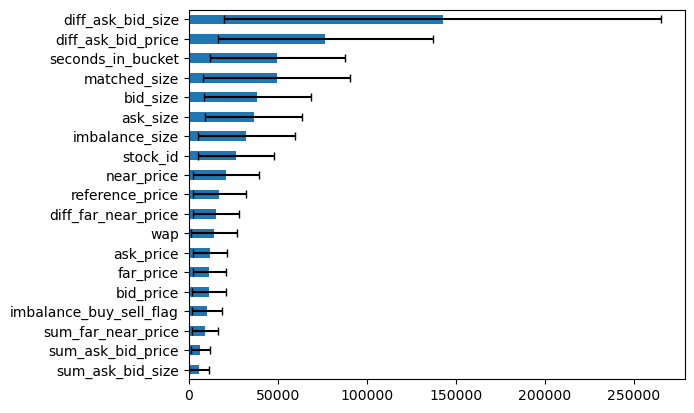

oof mae: 6.3887


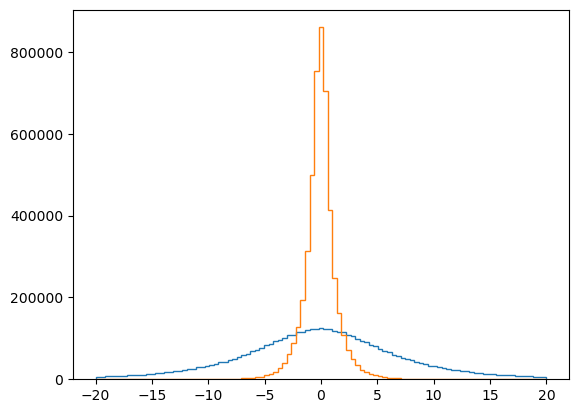

In [5]:
kfold_params = {
    'n_splits': 15,
    'max_train_size': 30,
    'test_size': 30,
    'gap': 0,
}

history = train_using_cv(
    kfold_params=kfold_params,
    dataset=train_df,
    outputs_dir=outputs_dir_path, 
)

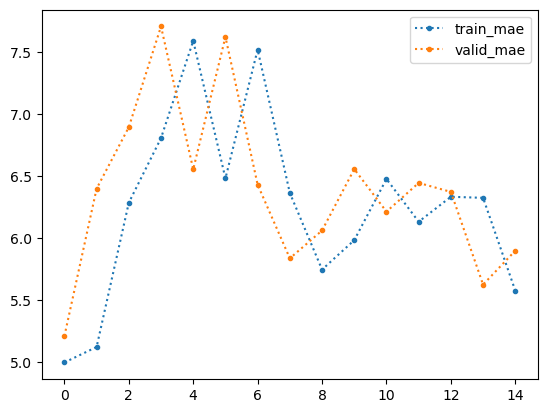

In [6]:
history.plot(marker='.', linestyle=':')
plt.show()